HIT PREDICTOR

Presentación del conjunto  de datos :  


	Estudio  de las características que caracterizan a los temas más escuchados estos últimos años ( TOPLIST) en SPOTIFY .
	Seleccionaremos las canciones más populares ( track_popularity > 70 ) para determinar si existen unas características sónicas ( features) propias que las definan.
	Cual alquimistas intentaremos encontrar “ la fórmula mágica” que determina la popularidad o no de una canción.
	Una vez tengamos esta “fórmula” , testaremos en otro dataset para ver si descubrimos canciones que por “fórmula” deberían ser populares pero no lo fueron. 


	
	El  dataset  con el entrenaremos al modelo contiene 32000 canciones y sus características sónicas ( Tono, escala, y coef.sintéticos ) así como su popularidad.
	El dataset con el que “testaremos” el modelo contiene 1M. canciones con sus características y su popularidad.
            

In [112]:
# importamos bibliotecas 

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


#from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score
#from sklearn.preprocessing import LabelEncoder, RobustScaler,MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score


#!pip install lazypredict
import lazypredict
from lazypredict.Supervised import LazyClassifier





    Cargamos este dataset con 32000 canciones y sus características sónicas( Tono, escala, y coef.sintéticos ) así como su popularidad.
    Seleccionaremos las canciones más populares ( track_popularity > 70  )

In [34]:
# cargamos Dataset    https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs


df = pd.read_csv('spotify_songs.csv')


# guardamos una copia del DF original
df_original = df.copy()

df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [35]:
df.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

Haremos un drop de muchas de estas columnas pues solo nos interesan las características sónicas, así que solo definiré las variables con las que finalmente trabajemos.



TRACK_POPULARITY : Popularidad de una canción. Se entiende que se estima según las escuchas. Cuanto más cercano a 100, más                    popular ha sido la canción ( más escuchas). 

KEY : Clave de la canción por semitonos . Así, 1 es DO,  2 es DO#,  3 es RE..etc hasta SI = 11. Var. Categórica

LOUDNESS :  “Volumen” medio  para una canción en dB .

MODE :  Tono MAYOR o MENOR de la canción . 1 si es MAYOR , 0 si es tono menor . Var. Categórica

SPEECHNESS : Determina la presencia de “partes” habladas en la canción. Así para podcasts / RAP/ Spoken words  este suele ser > 70  así como  valores  < 30 suelen definir temas musicales.
ACCOUSTICNESS: Acusticidad ( vs electricidad ) de las canciones . Canciones con instrumentos acústicos tendrán valores cercanos a 1 y presuponemos que temas más con instrumentos y timbres más eléctricos o electrónicos tendrán valores cercanos a 0 .

INSTRUMENTALNESS: Define la presencia o no de partes vocales en la canción. Cuanto más se acerca a  1 más instrumental es la canción. Esperamos valores cercanos a 1 para JAZZ, CLASSICA, ETC

LIVENESS: Define la presencia o no de público durante la grabación, define si la canción  ha sido gravada en Directo o en estudio. 

VALENCE : Define si una canción es “ triste”  (cercana a 0) o “alegre” (cercana a  1)

TEMPO :  Tempo de la canción en BPM

DURATION : Duración de la canción en Msegundos 


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

No hay valores nulos, nos evitamos : df.isnull().sum().

Nos quedaremos grosso modo con las variables numéricas que aparecen  con dtype  Float64.

In [37]:
df.describe()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,42.477081,0.654850,0.698619,5.374471,-6.719499,0.565711,0.107068,0.175334,0.084747,0.190176,0.510561,120.881132,225799.811622
std,24.984074,0.145085,0.180910,3.611657,2.988436,0.495671,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182
min,0.000000,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,24.000000,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,45.000000,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,62.000000,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,100.000000,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


Destacamos, pues es relevante para nuestro estudio:

que la media de Track_popularity es 42\
que el 75% de las muestras tienen una track_popularity inferior a 62

In [38]:
df.isnull().sum()

track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

In [43]:
df.dropna(inplace =  True)

In [44]:
df.isnull().sum()

track_id                    0
track_name                  0
track_artist                0
track_popularity            0
track_album_id              0
track_album_name            0
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

In [45]:
# Veamos si hay duplicados  

df.duplicated().sum()

0

In [46]:
df.convert_dtypes()


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.102,0.0,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.00421,0.357,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.11,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.102,0.0287,0.000009,0.204,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.0,0.0833,0.725,123.976,189052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,7bxnKAamR3snQ1VGLuVfC1,City Of Lights - Official Radio Edit,Lush & Simon,42,2azRoBBWEEEYhqV6sb7JrT,City Of Lights (Vocal Mix),2014-04-28,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,2,-1.814,1,0.0936,0.0766,0.0,0.0668,0.21,128.17,204375
32829,5Aevni09Em4575077nkWHz,Closer - Sultan & Ned Shepard Remix,Tegan and Sara,20,6kD6KLxj7s8eCE3ABvAyf5,Closer Remixed,2013-03-08,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,0,-4.462,1,0.042,0.00171,0.00427,0.375,0.4,128.041,353120
32830,7ImMqPP3Q1yfUHvsdn7wEo,Sweet Surrender - Radio Edit,Starkillers,14,0ltWNSY9JgxoIZO4VzuCa6,Sweet Surrender (Radio Edit),2014-04-21,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,6,-4.899,0,0.0481,0.108,0.000001,0.15,0.436,127.989,210112
32831,2m69mhnfQ1Oq6lGtXuYhgX,Only For You - Maor Levi Remix,Mat Zo,15,1fGrOkHnHJcStl14zNx8Jy,Only For You (Remixes),2014-01-01,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,2,-3.361,1,0.109,0.00792,0.127,0.343,0.308,128.008,367432


 Vamos a eliminar las columnas innecesarias para este estudio: track_id (0), track_name (1), track_artist (2), track_album_id(4),track_album_name (5), track_album_release_date (6)  playlist_name (7),playlist_id (8), playlist_genre (9) playlist_subgenre (10) ,duration_ms (22), track_album_release_year  (23)

In [47]:
df = df.drop(df.columns[[0,1,2,4,5,6,7,8,9,10,12,22]], axis= 1 )
df = df.round(decimals = 2)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32828 entries, 0 to 32832
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_popularity  32828 non-null  int64  
 1   danceability      32828 non-null  float64
 2   key               32828 non-null  int64  
 3   loudness          32828 non-null  float64
 4   mode              32828 non-null  int64  
 5   speechiness       32828 non-null  float64
 6   acousticness      32828 non-null  float64
 7   instrumentalness  32828 non-null  float64
 8   liveness          32828 non-null  float64
 9   valence           32828 non-null  float64
 10  tempo             32828 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 3.0 MB


# EDA

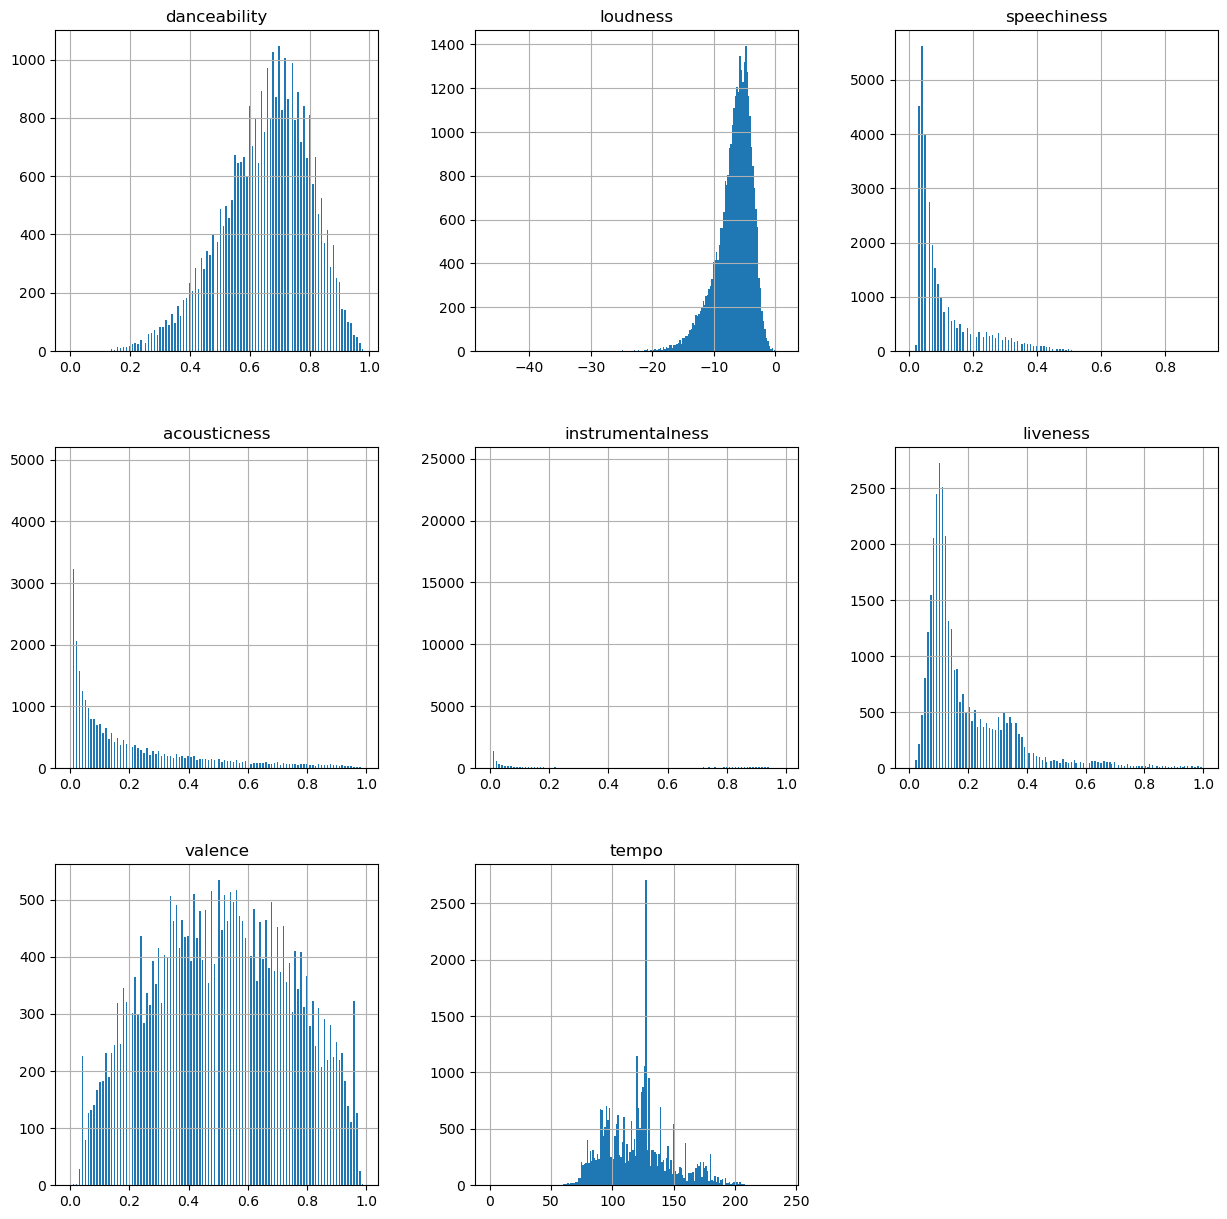

In [213]:
columns_numericas = df.select_dtypes(include=[ 'float64'])

df.hist(column = columns_numericas.columns, figsize = (15,15), bins = 200)
plt.show()

# EDA description...........complete

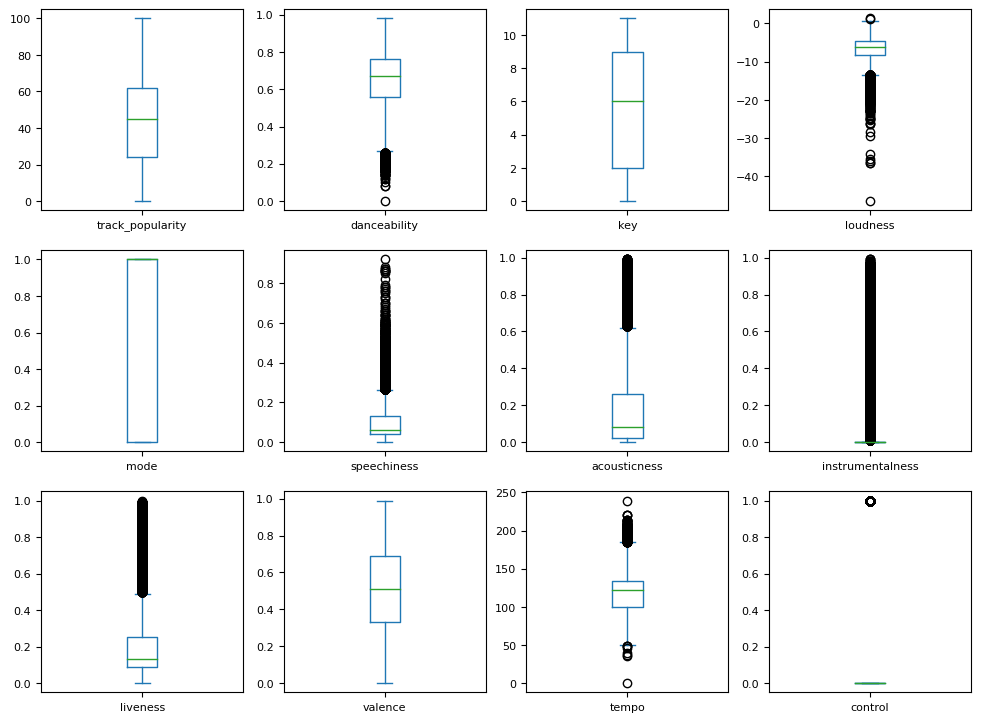

In [218]:
# Veamos si existen outliers visualmente

df.plot(subplots=True, kind = 'box' ,  layout=(4,4), fontsize=8, figsize=(12,12));

Vemos outliers para gran parte de las características. Aplicaremos RobustScaler cuando normalizemos el dataset.



In [51]:
# Veamos si las variables numéricas (KEY y MODE son variables categóricas, dtype:int64) tienen una distribución normal : 


# TEST SHAPIRO

from scipy.stats import shapiro

columns_numericas = df.select_dtypes(include=[ 'float64'])

 #Realizamos el test de Shapiro para cada columna numérica:
    
for column in columns_numericas:
    stat, p = shapiro(df[column])
    print(f'Columna: {column}, Estadística: {stat:.3f}, p-valor: {p:.3f}')
    
    

Columna: danceability, Estadística: 0.982, p-valor: 0.000
Columna: loudness, Estadística: 0.924, p-valor: 0.000
Columna: speechiness, Estadística: 0.741, p-valor: 0.000
Columna: acousticness, Estadística: 0.778, p-valor: 0.000
Columna: instrumentalness, Estadística: 0.428, p-valor: 0.000
Columna: liveness, Estadística: 0.774, p-valor: 0.000
Columna: valence, Estadística: 0.980, p-valor: 0.000
Columna: tempo, Estadística: 0.973, p-valor: 0.000


 Shapiro Test nos confirma que ninguna de estas características sigue una distribución normal ( rechazamos hip.nula pues que el p-value es menor a 0.05) ) . Confirma que podremos aplicar Robust Scaler más adelante.
KEY y MODE son variables categóricas, no aplica Shapiro Test.



CONTROL

Añadiremos una Columna ['control'] para clasificar las canciones segun su popularidad.

Como ya dijimos, cuanto más cercano a 100 és el valor de track_popularity, más popular ha sido una canción. 

Para nuestro estudio asumiremos que las canciones con track_popularity > 70 han sido canciones populares. 

Nos permitirá visualizar mediante ' Hue' las diferencias entre características para canciones populares y canciones no-populares . Será nuestra variable target a la hora de "entrenar" el modelo.

Crearemos dos subsets antagónicos :

     Canciones Populares( Top : track_popularity > 70 : track_popularity > 70 )  y características sónicas :[ Control] = 1
     Canciones Looser   (bottom track_popularity < 70 ) y características sónicas : [ Control] = 0


In [52]:
df['control'] = df['track_popularity'].apply(lambda x: 1 if x > 70 else  0)

df.head(5)

,track_popularity,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,control
0,66,0.75,6,-2.63,1,0.06,0.10,0.0,0.07,0.52,122.04,0
1,67,0.73,11,-4.97,1,0.04,0.07,0.0,0.36,0.69,99.97,0
2,70,0.68,1,-3.43,0,0.07,0.08,0.0,0.11,0.61,124.01,0
3,60,0.72,7,-3.78,1,0.10,0.03,0.0,0.20,0.28,121.96,0
4,69,0.65,1,-4.67,1,0.04,0.08,0.0,0.08,0.72,123.98,0


In [53]:
df.shape

(32828, 12)

Pequeños gráficos pairplot vs track_popularity

Visualizaremos diferencias entre TOP y BOTTOM mediante Hue (df[control]). 

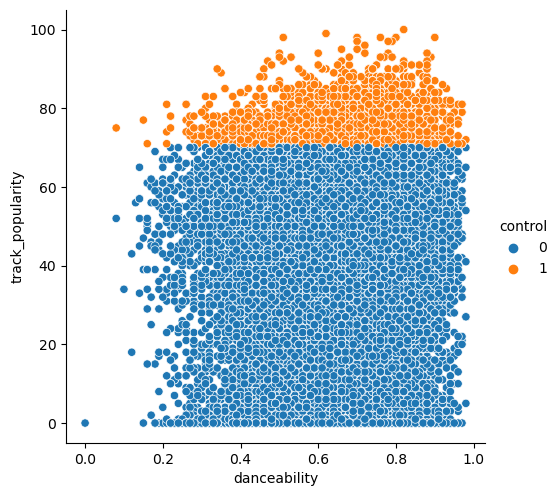

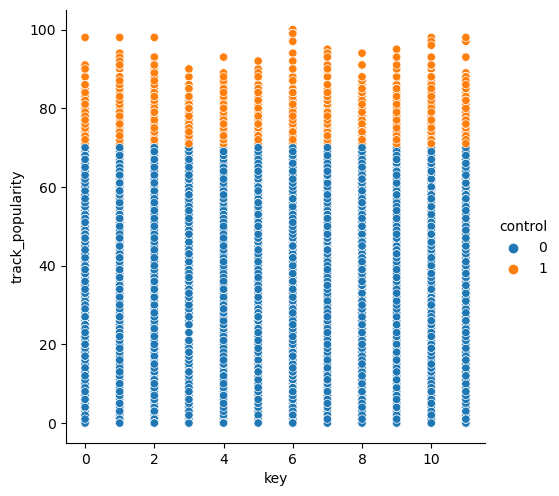

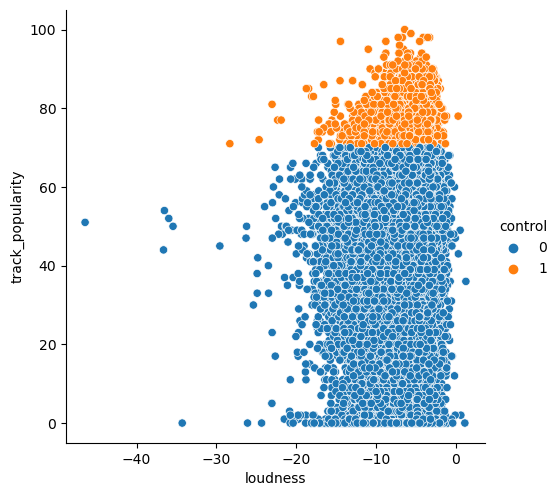

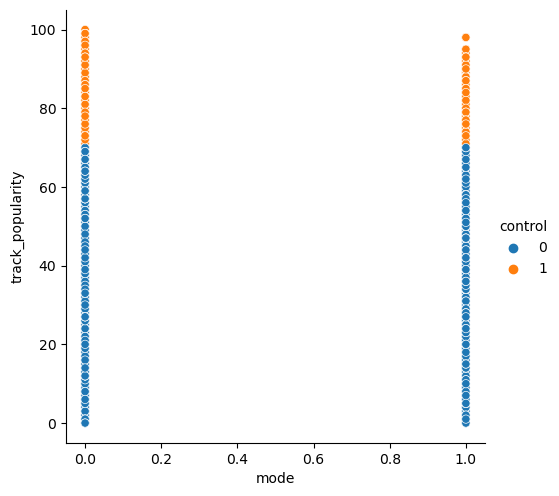

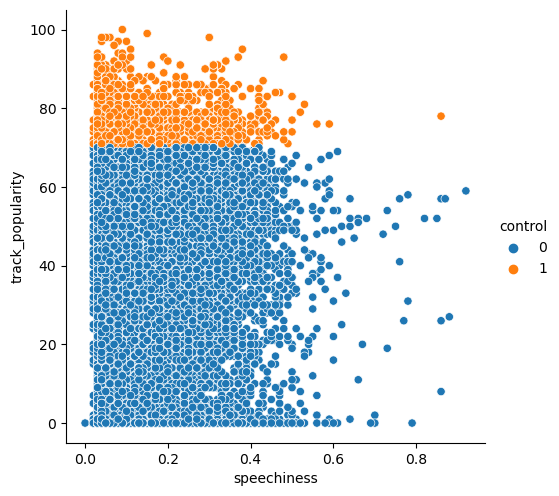

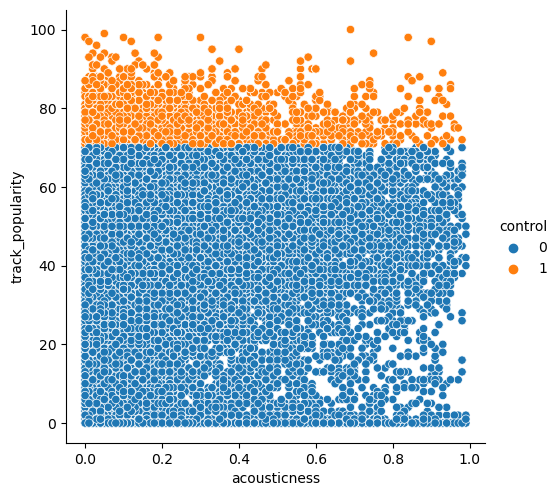

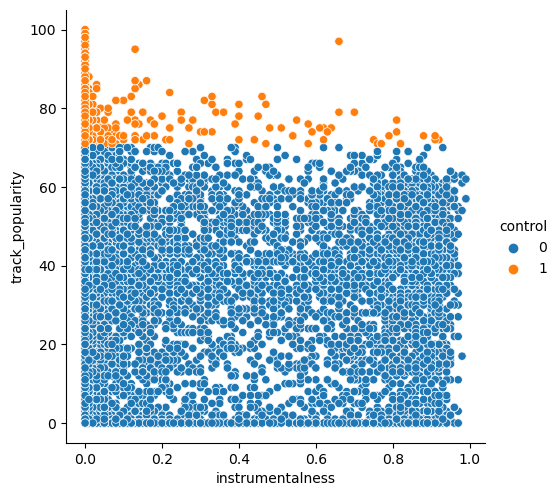

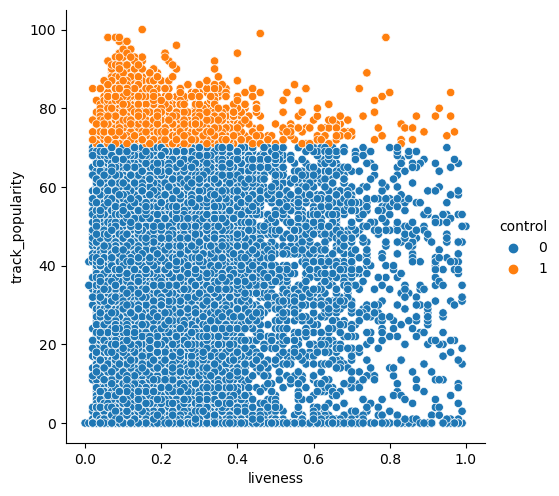

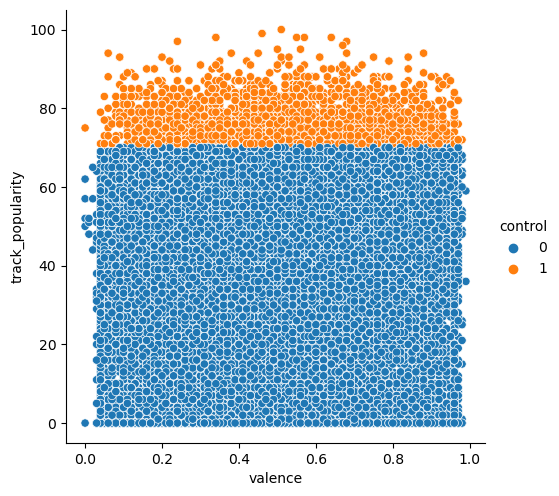

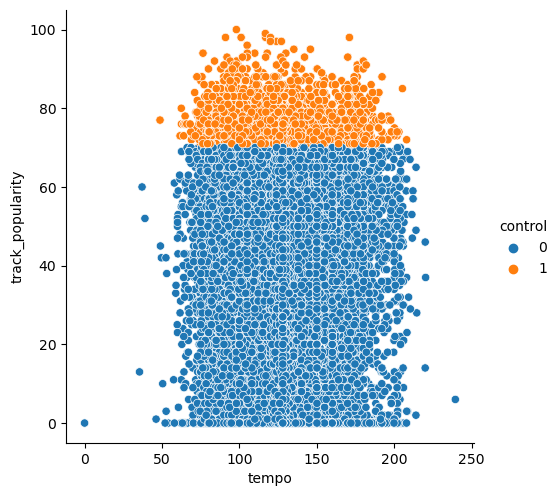

In [54]:
# Creamos subplots para cada feature




for i in range(1,(len(df.columns)-1)) :                       # evitamos la posición [0] porque es 'track_popularity' 
                                                                  #  [1] porque es Genre ( categórica)
                                                                  # [16] porque es control (  Hue )
            
    sns.pairplot(df,  hue = 'control', x_vars=df.columns[i], y_vars=['track_popularity'],height=5)
  
   

No vemos grandes diferencias en cuanto a distribucion por features vs.track_popularity
..será difícil llegar al objetivo de classificar las canciones TOP...
Sí vemos que el subset TOP es mucho menor que el subset BOTTOM.



Veamos si existen diferencias en cuanto a correlaciones entre variables para ambos grupos ( TOP y BOTTOM )

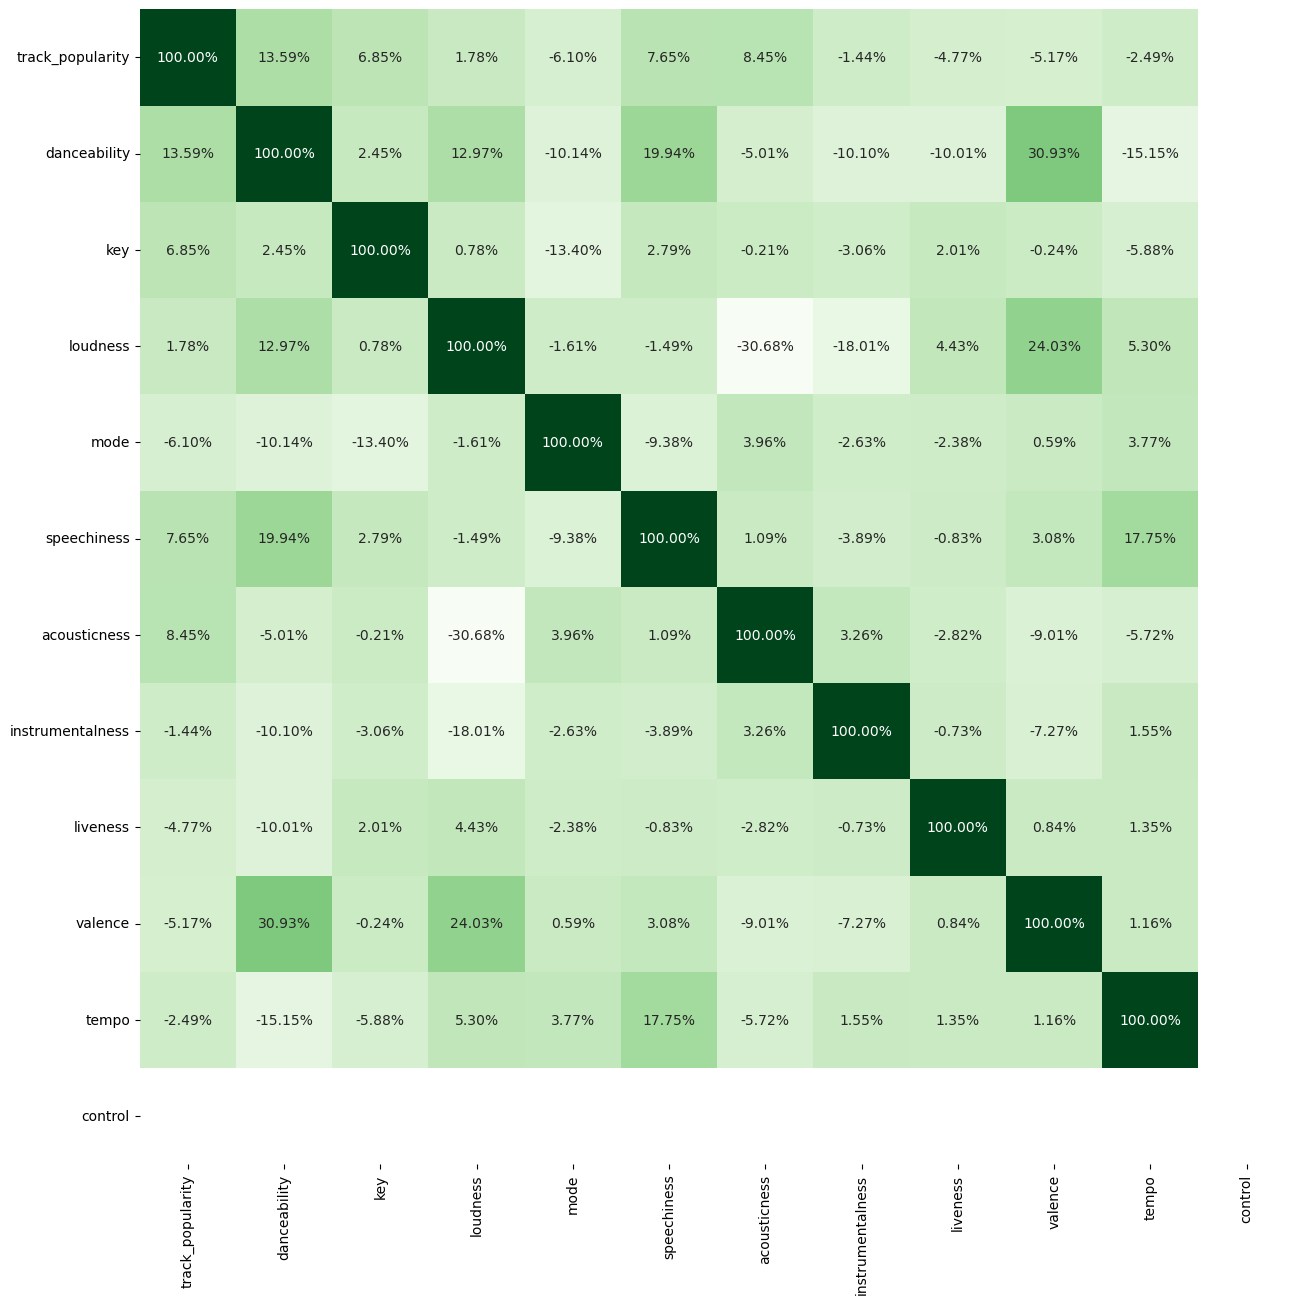

In [55]:
# Correlaciones entre features de Canciones TOP

df_Canciones_top=  df.query('control == 1')
corr_Top = df_Canciones_top.corr()


# Diseño 
plt.figure(figsize=(15,15))
plt.tight_layout


heatmap =sns.heatmap(corr_Top, cbar = False, square= True, fmt='.2%', annot=True, cmap='Greens')

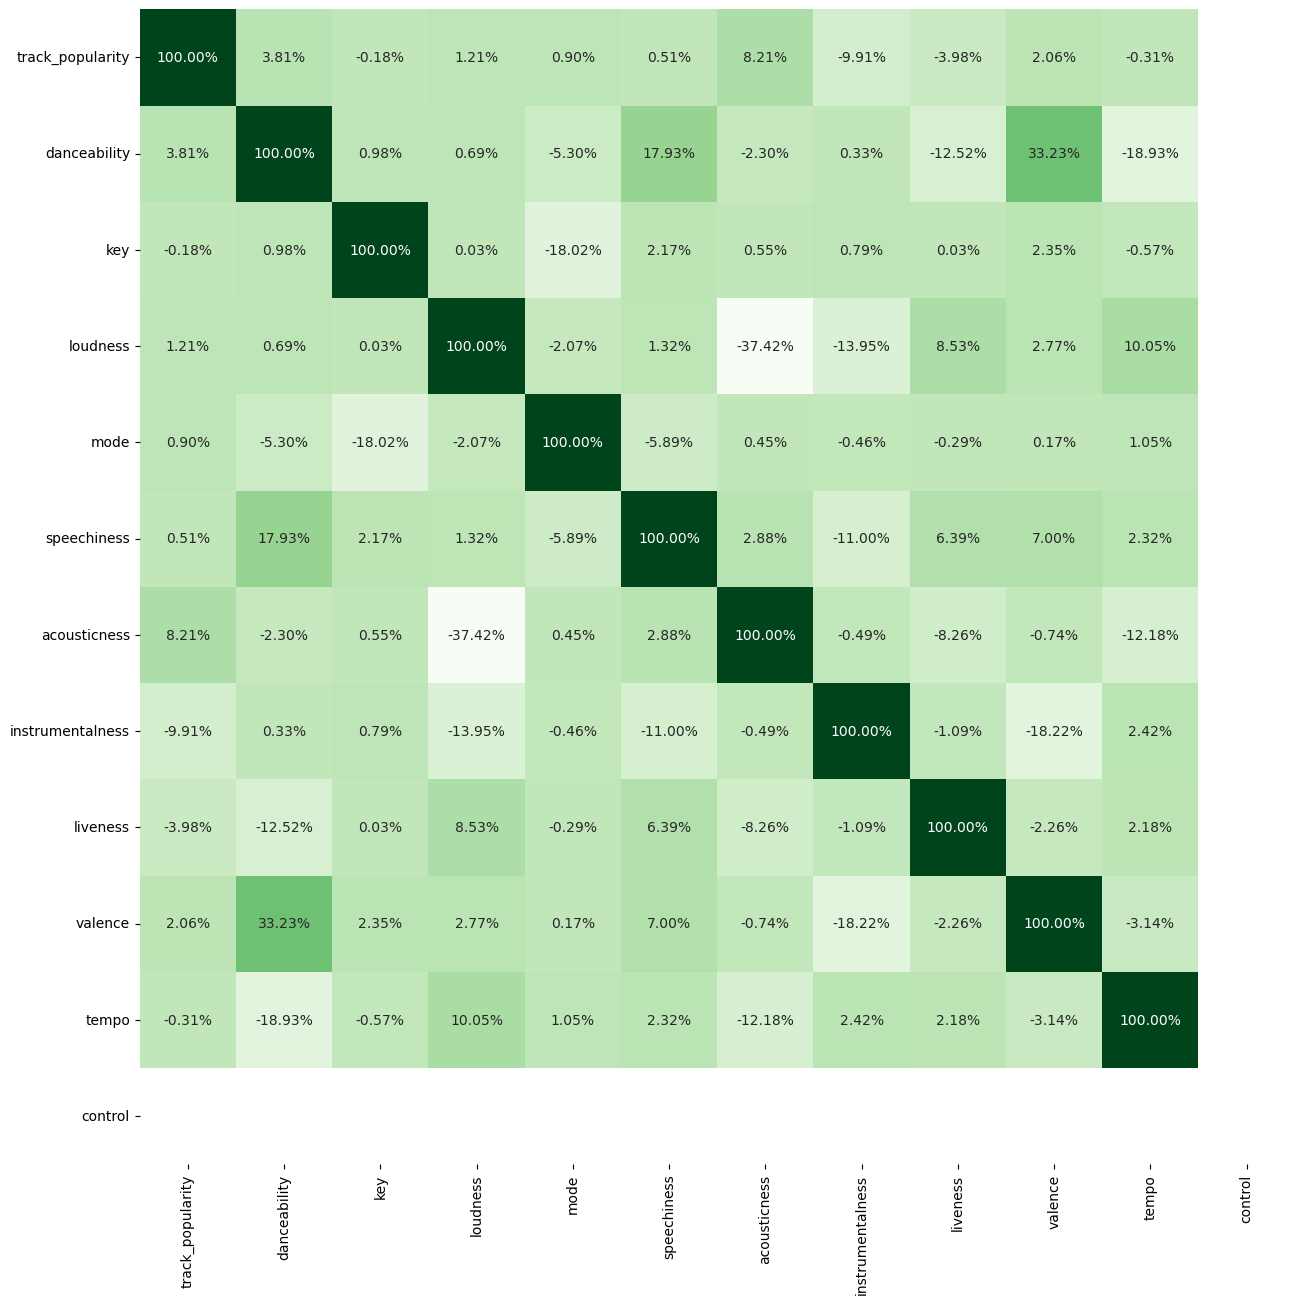

In [56]:
# Correlaciones entre features de Canciones BOTTOM 

df_Canciones_bottom =  df.query('control == 0')
corr_bottom = df_Canciones_bottom.corr()
corr_bottom_popularity = corr_bottom.iloc[0]

# Diseño 
plt.figure(figsize=(15,15))
plt.tight_layout


heatmap =sns.heatmap(corr_bottom, cbar = False, square= True, fmt='.2%', annot=True, cmap='Greens')

De hecho solo nos interesa comparar correlaciones entre track_popularity y las diferentes features para ambos grupos de Control ( TOP (1) y BOTTOM(0))  
Crearemos un DataFrame donde reflejar las diferencias de estos dos grupos en cuanto a correlaciones por feature.    
    

In [57]:
data2 = []
for i in range(len(corr_Top.columns)-2):
    column_name = corr_Top.columns[i]
    corr_top_value = corr_Top.iloc[0, i]
    corr_bottom_value = corr_bottom.iloc[0, i]
    data2.append([column_name, corr_top_value, corr_bottom_value])

df_combined = pd.DataFrame(data2, columns=['Column_Name', 'Corr_Top_Value', 'Corr_Bottom_Value'])
print(df_combined)

        Column_Name  Corr_Top_Value  Corr_Bottom_Value
0  track_popularity        1.000000           1.000000
1      danceability        0.135887           0.038070
2               key        0.068543          -0.001778
3          loudness        0.017846           0.012120
4              mode       -0.060959           0.009000
5       speechiness        0.076450           0.005106
6      acousticness        0.084489           0.082129
7  instrumentalness       -0.014434          -0.099081
8          liveness       -0.047687          -0.039822
9           valence       -0.051656           0.020556


No vemos grandes diferencias en cuanto a correlaciones x feature y grupo de control. Si acaso : 

    Danceability : 0.13 TOP vs 0.03  BOTTOM ...las canciones TOP suelen ser ligeramente más bailables.
    
    Speechness   : 0.07 TOP vs 0.004 BOTTOM ...las canciones TOP suelen incluir más partes "habladas", mas "Lyrics". 
    
    Instrumentalness : -0.014 TOP vs - 0.09 BOTTOM .. las canciones TOP son menos instrumentales que las canciones BOTTOM.                                                Confirma en cierta forma la importancia de las lyrics en cuanto a la                                                        popularidad de una canción ( que no calidad )
    
    Valence : -0.051 TOP vs 0.02 BOTTOM     ...las canciones TOP guardan una mínima correlación negativa con Valence y las                                                canciones BOTTOM guardan una mínima correlación positiva con VALENCE.
                                               las canciones TOP suelen ser más alegres que las canciones BOTTOM.
    

# Transformaciones

Con estos dos grupos de control "entrenaremos" al modelo .
Definimos 'X' e 'y' (target).
Hacemos la división train test . Aplicamos un escalado previo

In [58]:
# Asignamos la variable target 
X = df.drop(['control','track_popularity'], axis=1) # drop de  track_popularity una vez ya tenemos la columna control, no afectase al entreno( colinealidad con Control)
y = df['control']

In [59]:
y.value_counts()

0    28404
1     4424
Name: control, dtype: int64

Vemos que el subset TOP (1) es mucho menor que el subset BOTTOM (0).
Intentaremos utilizar técnicas de Over-sampling/ Undersampling para paliar posibles sesgos.
Utilizaremos SMOTE (Synthetic Minority Over-sampling Technique)

In [60]:
from imblearn.over_sampling import SMOTE

# Implement SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X, y)


In [61]:
y_train_smote.value_counts()

0    28404
1    28404
Name: control, dtype: int64

Vemos como las clases se han igualado.


Haremos pues el train_test Split con este X_train_smote (no confundir)

In [63]:
# Train/ test Split 

X_train, X_test, y_train, y_test = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=42)


In [66]:
# Inicializar el RobustScaler
scaler = RobustScaler()

# Ajustar y transformar los datos de entrenamiento
X_train_scaled =scaler.fit_transform(X_train)

# Solo transformar los datos de prueba (no volver a ajustar para evitar data leakage)
X_test_scaled = scaler.transform(X_test)

In [67]:
# Utilizaremos lazypredict para ver que algoritmo es más adecuado. 

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)
models

 97%|█████████▋| 28/29 [22:50<00:38, 38.11s/it] 

[LightGBM] [Info] Number of positive: 22609, number of negative: 22837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 45446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497492 -> initscore=-0.010034
[LightGBM] [Info] Start training from score -0.010034


100%|██████████| 29/29 [22:50<00:00, 47.27s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.95,0.95,0.95,0.95,15.84
ExtraTreesClassifier,0.94,0.94,0.94,0.94,5.38
BaggingClassifier,0.93,0.93,0.93,0.93,4.49
XGBClassifier,0.91,0.91,0.91,0.91,0.71
DecisionTreeClassifier,0.88,0.88,0.88,0.88,0.54
LGBMClassifier,0.88,0.88,0.88,0.88,0.74
ExtraTreeClassifier,0.84,0.84,0.84,0.84,0.08
KNeighborsClassifier,0.83,0.83,0.83,0.83,3.09
NuSVC,0.79,0.79,0.79,0.79,527.00


Tras una primera prueba con RandomForest, y ver que clasifica muy bien para el grupo 0 pero muy mal para el grupo 1 ( el que nos interesa TOP) optaremos por KNeighborsClassifier 

In [68]:
# KneighborsClassifier

from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier()
knn.get_params()



{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [69]:
#  Parametros sobre los que vamos a iterar CV

param_grid = {'algorithm': ['auto'],
'leaf_size': [100,30,20,10],
    'metric': ['minkowski'],
        'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,100,200,500],
            'p': [2,3,4],
                'weights': ['uniform']}

In [70]:
# RandomizedSearchCV y fit()del modelo KNN

grid_search1 = RandomizedSearchCV(knn, param_grid, n_iter=20, cv=5, verbose = 2, scoring='accuracy', n_jobs=-1)


        
grid_search1.fit(X_train_scaled, y_train)
grid_search1.best_params_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'weights': 'uniform',
 'p': 2,
 'n_neighbors': 1,
 'metric': 'minkowski',
 'leaf_size': 10,
 'algorithm': 'auto'}

In [71]:
best_model_knn = grid_search1.best_estimator_ # mejor modelo con el mejor estimador tras GridSearch


In [72]:
y_pred_knn = best_model_knn.predict(X_test_scaled) # Predicción una vez tenemos el mejor modelo 


              precision    recall  f1-score   support

           0       0.94      0.81      0.87      5567
           1       0.84      0.95      0.89      5795

    accuracy                           0.88     11362
   macro avg       0.89      0.88      0.88     11362
weighted avg       0.89      0.88      0.88     11362



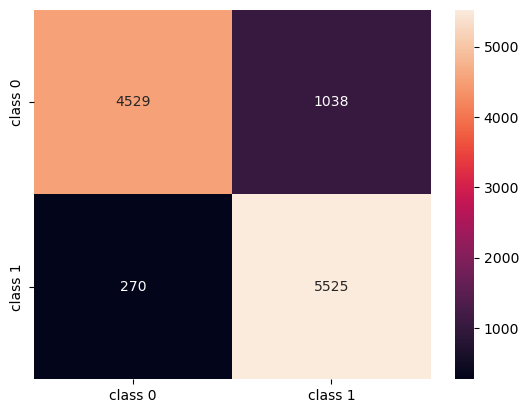

In [73]:
from sklearn.metrics import classification_report, confusion_matrix


# Añadimos  classes para una mejor interpretación.

classes_names = ['class 0','class 1']
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_knn), 
                  columns=classes_names, index = classes_names)
                  
# Seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d');

print(classification_report(y_test, y_pred_knn))

Ajuste muy bueno ( f1_score = 89%  para canciones TOP, class1 ), objeto del estudio..cual es la formula mágica ? ).
Ajusta menos bien a la hora de predecir canciones que no van a ser populares. ( Class 0 ). 


Busquemos el K óptimo a ver si ajusta mejor

In [74]:
# Calculamos  f1 score para K values entre  1 y 20

from sklearn.metrics import f1_score

f1s = []

for i in range(1, 20):
    knn1 = KNeighborsClassifier(n_neighbors=i)
    knn1.fit(X_train_scaled, y_train)
    pred_i = knn1.predict(X_test_scaled)
    #  average='weighted' para calcular una media ponderada de las 3 classes 
    f1s.append(f1_score(y_test, pred_i, average='weighted'))

Text(0, 0.5, 'F1 Score')

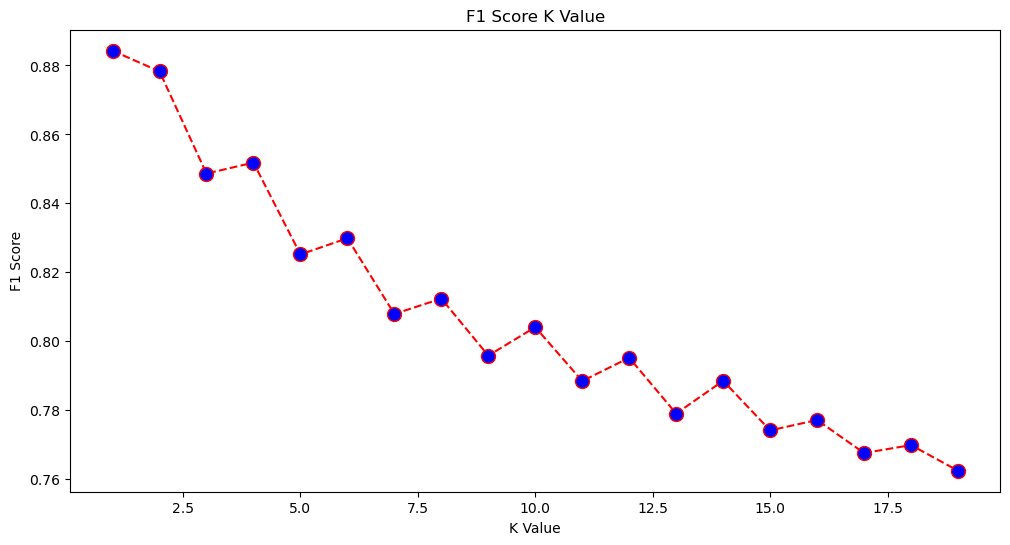

In [75]:
# PLOT

plt.figure(figsize=(12, 6))
plt.plot(range(1, 20), f1s, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('F1 Score K Value')
plt.xlabel('K Value')
plt.ylabel('F1 Score')

El mejor F1-score es cuando k = 2..vamos a entrenar de nuevo nuestro modelo con K = 2

In [76]:
clf2 = KNeighborsClassifier(n_neighbors=2)
clf2.fit(X_train_scaled, y_train)
y_pred2 = clf2.predict(X_test_scaled)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5567
           1       0.88      0.88      0.88      5795

    accuracy                           0.88     11362
   macro avg       0.88      0.88      0.88     11362
weighted avg       0.88      0.88      0.88     11362



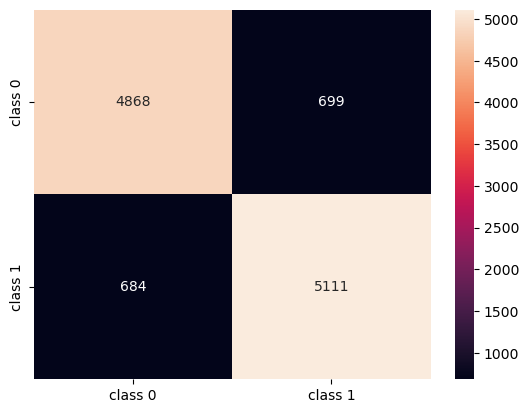

In [77]:
# Adding classes names for better interpretation
classes_names = ['class 0','class 1']
cm = pd.DataFrame(confusion_matrix(y_test, y_pred2), 
                  columns=classes_names, index = classes_names)
                  
# Seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d');



Esta vez, con "k" optimizado , ajusta peor para Class1 ( f1-score : 0.88) y mejora el ajuste para Class0 (0.88 a 0.91). De todas formas, nuestro objetivo es " capturar" las características del Grupo 1 - No sé hasta que punto las mínimas mejores en accuracy alterarán la "composición"

In [79]:
# Comparamos Scores : 
    
print (classification_report(y_test, y_pred_knn))
print (classification_report(y_test, y_pred2))


              precision    recall  f1-score   support

           0       0.94      0.81      0.87      5567
           1       0.84      0.95      0.89      5795

    accuracy                           0.88     11362
   macro avg       0.89      0.88      0.88     11362
weighted avg       0.89      0.88      0.88     11362

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5567
           1       0.88      0.88      0.88      5795

    accuracy                           0.88     11362
   macro avg       0.88      0.88      0.88     11362
weighted avg       0.88      0.88      0.88     11362



Pasamos a realizar el cross validation de nuestro modelo.

In [80]:
# Realizamos validación cruzada
cv_scores_knn = cross_val_score(best_model_knn, X_train_smote, y_train_smote, cv=5, scoring='accuracy')



print("Precisión para cada fold:", cv_scores_knn)
print("Precisión media:", cv_scores_knn.mean())
print("Desviación estándar :", cv_scores_knn.std())

Precisión para cada fold: [0.87070938 0.89676113 0.88338321 0.89243905 0.8995687 ]
Precisión media: 0.8885722937466255
Desviación estándar : 0.010477977374247096


Cross Validation valida el rendimiento de nuestro modelo.

# Parte 2

Aplicamos las predicciones a un segundo dataset.(https://www.kaggle.com/datasets/amitanshjoshi/spotify-1million-tracks)

Queremos detectar canciones que deberían estar en Class1 ( TOP ) y que sin embargo no son populares ( track_popularity < 70 ) 

In [179]:
data3 =  pd.read_csv('spotify_data.csv')
df2 = pd.DataFrame(data3)
df2.shape

(1159764, 20)

In [180]:
df2.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.48,0.30,4,-10.06,1,0.04,0.69,0.00,0.12,0.14,133.41,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.57,0.45,3,-10.29,1,0.03,0.48,0.00,0.10,0.52,140.18,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.41,0.23,3,-13.71,1,0.03,0.34,0.00,0.09,0.14,139.83,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.39,0.25,10,-9.85,1,0.04,0.81,0.00,0.08,0.51,204.96,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.43,0.79,6,-5.42,0,0.03,0.07,0.02,0.11,0.22,171.86,244320,4


In [181]:
# Drop Duplicates


df2['track_id'] = df2['track_id'].astype('category')
df2.drop_duplicates(subset=['track_id']). reset_index(drop = True)
df2.shape 

(1159764, 20)

In [182]:
df2.isnull().sum()

Unnamed: 0          0
artist_name         0
track_name          0
track_id            0
popularity          0
year                0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

No existen duplicados, por lo menos en cuanto a 'track_id', quizás si mirasemos por Track_name/ Artist encontraríamos.

In [183]:
df2.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   Unnamed: 0        1159764 non-null  int64   
 1   artist_name       1159764 non-null  object  
 2   track_name        1159764 non-null  object  
 3   track_id          1159764 non-null  category
 4   popularity        1159764 non-null  int64   
 5   year              1159764 non-null  int64   
 6   genre             1159764 non-null  object  
 7   danceability      1159764 non-null  float64 
 8   energy            1159764 non-null  float64 
 9   key               1159764 non-null  int64   
 10  loudness          1159764 non-null  float64 
 11  mode              1159764 non-null  int64   
 12  speechiness       1159764 non-null  float64 
 13  acousticness      1159764 non-null  float64 
 14  instrumentalness  1159764 non-null  float64 
 15  liveness          1159764 non-nu

Tampoco existen Null_values() en este Dataset de 1 M. de canciones

Aplicamos Drops, etc para que los 2 DF tengan el mismo formato

In [184]:
df2.drop(df2.columns[[0,1,2,3,5,6,8,18,19]], axis= 1, inplace =  True ) # drop de las mismas columnas para que tengan el mismo formato

In [185]:
df2.head()

,popularity,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,68,0.48,4,-10.06,1,0.04,0.69,0.00,0.12,0.14,133.41
1,50,0.57,3,-10.29,1,0.03,0.48,0.00,0.10,0.52,140.18
2,57,0.41,3,-13.71,1,0.03,0.34,0.00,0.09,0.14,139.83
3,58,0.39,10,-9.85,1,0.04,0.81,0.00,0.08,0.51,204.96
4,54,0.43,6,-5.42,0,0.03,0.07,0.02,0.11,0.22,171.86


Y añadiremos una columna de nuevo con las Class 0 y 1 (> 70 track_popularity) para comparar con predicted_popularity

In [186]:
df2['control'] = df2['popularity'].apply(lambda x: 1 if x > 70 else  0)
df2

,popularity,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,control
0,68,0.48,4,-10.06,1,0.04,0.69,0.00,0.12,0.14,133.41,0
1,50,0.57,3,-10.29,1,0.03,0.48,0.00,0.10,0.52,140.18,0
2,57,0.41,3,-13.71,1,0.03,0.34,0.00,0.09,0.14,139.83,0
3,58,0.39,10,-9.85,1,0.04,0.81,0.00,0.08,0.51,204.96,0
4,54,0.43,6,-5.42,0,0.03,0.07,0.02,0.11,0.22,171.86,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1159759,4,0.37,10,-6.45,0,0.07,0.33,0.00,0.16,0.52,107.95,0
1159760,3,0.52,7,-7.59,0,0.03,0.79,0.00,0.13,0.26,119.90,0
1159761,2,0.49,5,-8.51,1,0.03,0.48,0.00,0.09,0.04,100.08,0
1159762,0,0.48,0,-13.34,1,0.03,0.43,0.00,0.12,0.20,133.88,0


In [187]:
df2.dtypes

popularity            int64
danceability        float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
control               int64
dtype: object

Aplicaremos Robust Scaler a todo el dataframe (df1, solo a las variables float 64). El escalado debe ser el mismo, en caso contrario los resultados de aplicar el modelo se distorsionarían ( presuponemos que al ser ambos de Spotify podemos aplicar el mismo escalado )

In [188]:
numeric_features = df2.select_dtypes(include=[ 'float64'])
numeric_transformer =[ 
        
        ('robust', RobustScaler())]
    

In [189]:
ColumnTransformer(
    [
        
        ('numericals', numeric_transformer, numeric_features),
        
    ]
)
# con remainder eliminaríamos las columnas que no estan especificas 

ColumnTransformer(transformers=[('numericals', [('robust', RobustScaler())],
                                          danceability  loudness  speechiness  acousticness  instrumentalness  \
0                0.48    -10.06         0.04          0.69              0.00   
1                0.57    -10.29         0.03          0.48              0.00   
2                0.41    -13.71         0.03          0.34              0.00   
3                0.39     -9.85         0.04          0.81              0.00   
4                0.43     -5.42         0.03          0.07              0.02   
...               ...       ...          ...           ...               ...   
1159759          0.37     -6.45         0.07          0.33              0.00   
1159760          0.52     -7.59         0.03          0.79              0.00   
1159761          0.49     -8.51         0.03          0.48              0.00   
1159762          0.48    -13.34         0.03          0.43              0.00   
1159763          0.78     -7.29         0.12          0.22              0.00   

         liveness  valence  tempo  
0            0.12     0.14 133.41  
1            0.10     0.52 140.18  
2            0.09     0.14 139.83  
3            0.08     0.51 204.96  
4            0.11     0.22 171.86  
...           ...      ...    ...  
1159759      0.16     0.52 107.95  
1159760      0.13     0.26 119.90  
1159761      0.09     0.04 100.08  
1159762      0.12     0.20 133.88  
1159763      0.06     0.86  89.99  

[1159764 rows x 8 columns])])

In [190]:
df2

,popularity,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,control
0,68,0.48,4,-10.06,1,0.04,0.69,0.00,0.12,0.14,133.41,0
1,50,0.57,3,-10.29,1,0.03,0.48,0.00,0.10,0.52,140.18,0
2,57,0.41,3,-13.71,1,0.03,0.34,0.00,0.09,0.14,139.83,0
3,58,0.39,10,-9.85,1,0.04,0.81,0.00,0.08,0.51,204.96,0
4,54,0.43,6,-5.42,0,0.03,0.07,0.02,0.11,0.22,171.86,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1159759,4,0.37,10,-6.45,0,0.07,0.33,0.00,0.16,0.52,107.95,0
1159760,3,0.52,7,-7.59,0,0.03,0.79,0.00,0.13,0.26,119.90,0
1159761,2,0.49,5,-8.51,1,0.03,0.48,0.00,0.09,0.04,100.08,0
1159762,0,0.48,0,-13.34,1,0.03,0.43,0.00,0.12,0.20,133.88,0


Ahora aplicamos nuestro mejor modelo obtenido con KNN ( best_model_knn ) al conjunto de datos:

In [191]:
# Realizamos predicciones en este segundo conjunto de datos

best_model_knn

KNeighborsClassifier(leaf_size=10, n_neighbors=1)

In [192]:
df3 = df2.drop(['control','popularity'], axis=1) # drop de  popularity una vez ya tenemos la columna control, no afectase al entreno( colinealidad con Control)

    
    
    
predicted_popularity = best_model_knn.predict(df3)

In [237]:
predicted_popularity

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [172]:
df3.head()

,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.48,4,-10.06,1,0.04,0.69,0.00,0.12,0.14,133.41
1,0.57,3,-10.29,1,0.03,0.48,0.00,0.10,0.52,140.18
2,0.41,3,-13.71,1,0.03,0.34,0.00,0.09,0.14,139.83
3,0.39,10,-9.85,1,0.04,0.81,0.00,0.08,0.51,204.96
4,0.43,6,-5.42,0,0.03,0.07,0.02,0.11,0.22,171.86


Una vez obtenidas las previsiones de Class ( Class 0 y Class 1 ), los adjuntamos en una nueva columna, que creamos en nuestro dataframe 'df2'. 

In [193]:
df2['predicted_popularity'] = predicted_popularity

In [238]:
df2.head()

,popularity,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,control,predicted_popularity
0,68,0.48,4,-10.06,1,0.04,0.69,0.00,0.12,0.14,133.41,0,0
1,50,0.57,3,-10.29,1,0.03,0.48,0.00,0.10,0.52,140.18,0,0
2,57,0.41,3,-13.71,1,0.03,0.34,0.00,0.09,0.14,139.83,0,0
3,58,0.39,10,-9.85,1,0.04,0.81,0.00,0.08,0.51,204.96,0,0
4,54,0.43,6,-5.42,0,0.03,0.07,0.02,0.11,0.22,171.86,0,0


Ahora podemos comparar predicted_popularity ( segun KNN y features sónicas ) y track_popularity (control) para ver hasta que punto nuestro modelo ajustó correctamente.

In [194]:
# Buscamos las "perlas", canciones que por características ( segun algoritmo de class por features sónicas) deberían ser populares ( predicted_popularity = 1) y que sin embargo no alcanzaron popularidad ( control = 0) 

df_pearl = df2.query('control == 0 & predicted_popularity == 1 & 30 <popularity < 60')

In [195]:
# y comparamos que características distingun a las "perlas" de las canciones que sí fueron populares,

df_pearl.describe()

,popularity,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,control,predicted_popularity
count,3262.00,3262.00,3262.00,3262.00,3262.00,3262.00,3262.00,3262.00,3262.00,3262.00,3262.00,3262.00,3262.00
mean,39.13,0.30,5.20,-26.79,0.67,0.05,0.93,0.85,0.14,0.15,78.62,0.00,1.00
std,6.92,0.15,3.46,4.31,0.47,0.04,0.15,0.21,0.14,0.14,16.10,0.00,0.00
min,31.00,0.00,0.00,-47.56,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,1.00
25%,34.00,0.17,2.00,-28.87,0.00,0.04,0.94,0.87,0.09,0.04,68.91,0.00,1.00
50%,37.00,0.29,5.00,-26.37,1.00,0.04,0.98,0.92,0.11,0.10,75.63,0.00,1.00
75%,43.00,0.41,8.00,-24.07,1.00,0.05,0.99,0.94,0.12,0.20,84.52,0.00,1.00
max,59.00,0.84,11.00,-3.34,1.00,0.91,1.00,1.00,0.99,0.97,169.67,0.00,1.00


In [196]:
df_Canciones_top.describe()

,track_popularity,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,control
count,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00,4424.00
mean,78.39,0.68,5.35,-6.08,0.58,0.11,0.19,0.01,0.17,0.53,120.61,1.00
std,6.22,0.14,3.65,2.53,0.49,0.10,0.22,0.08,0.14,0.22,28.31,0.00
min,71.00,0.08,0.00,-28.31,0.00,0.02,0.00,0.00,0.02,0.00,48.72,1.00
25%,74.00,0.58,2.00,-7.18,0.00,0.04,0.03,0.00,0.09,0.36,97.95,1.00
50%,77.00,0.69,6.00,-5.72,1.00,0.06,0.11,0.00,0.12,0.53,118.03,1.00
75%,82.00,0.78,9.00,-4.35,1.00,0.13,0.29,0.00,0.21,0.70,136.97,1.00
max,100.00,0.98,11.00,0.30,1.00,0.86,0.98,0.92,0.97,0.98,207.97,1.00


In [226]:
df_pearl.shape

(3262, 13)

In [239]:

df_pearl[['danceability','loudness','acousticness','instrumentalness','valence','tempo']].describe()

,danceability,loudness,acousticness,instrumentalness,valence,tempo
count,3262.00,3262.00,3262.00,3262.00,3262.00,3262.00
mean,0.30,-26.79,0.93,0.85,0.15,78.62
std,0.15,4.31,0.15,0.21,0.14,16.10
min,0.00,-47.56,0.00,0.00,0.00,0.00
25%,0.17,-28.87,0.94,0.87,0.04,68.91
50%,0.29,-26.37,0.98,0.92,0.10,75.63
75%,0.41,-24.07,0.99,0.94,0.20,84.52
max,0.84,-3.34,1.00,1.00,0.97,169.67


In [240]:
# Haremos un df_pearl sin [predicted_popularity] solo para mejor visualización
df_pearl_graf = df_pearl.drop(['predicted_popularity'], axis = 1)

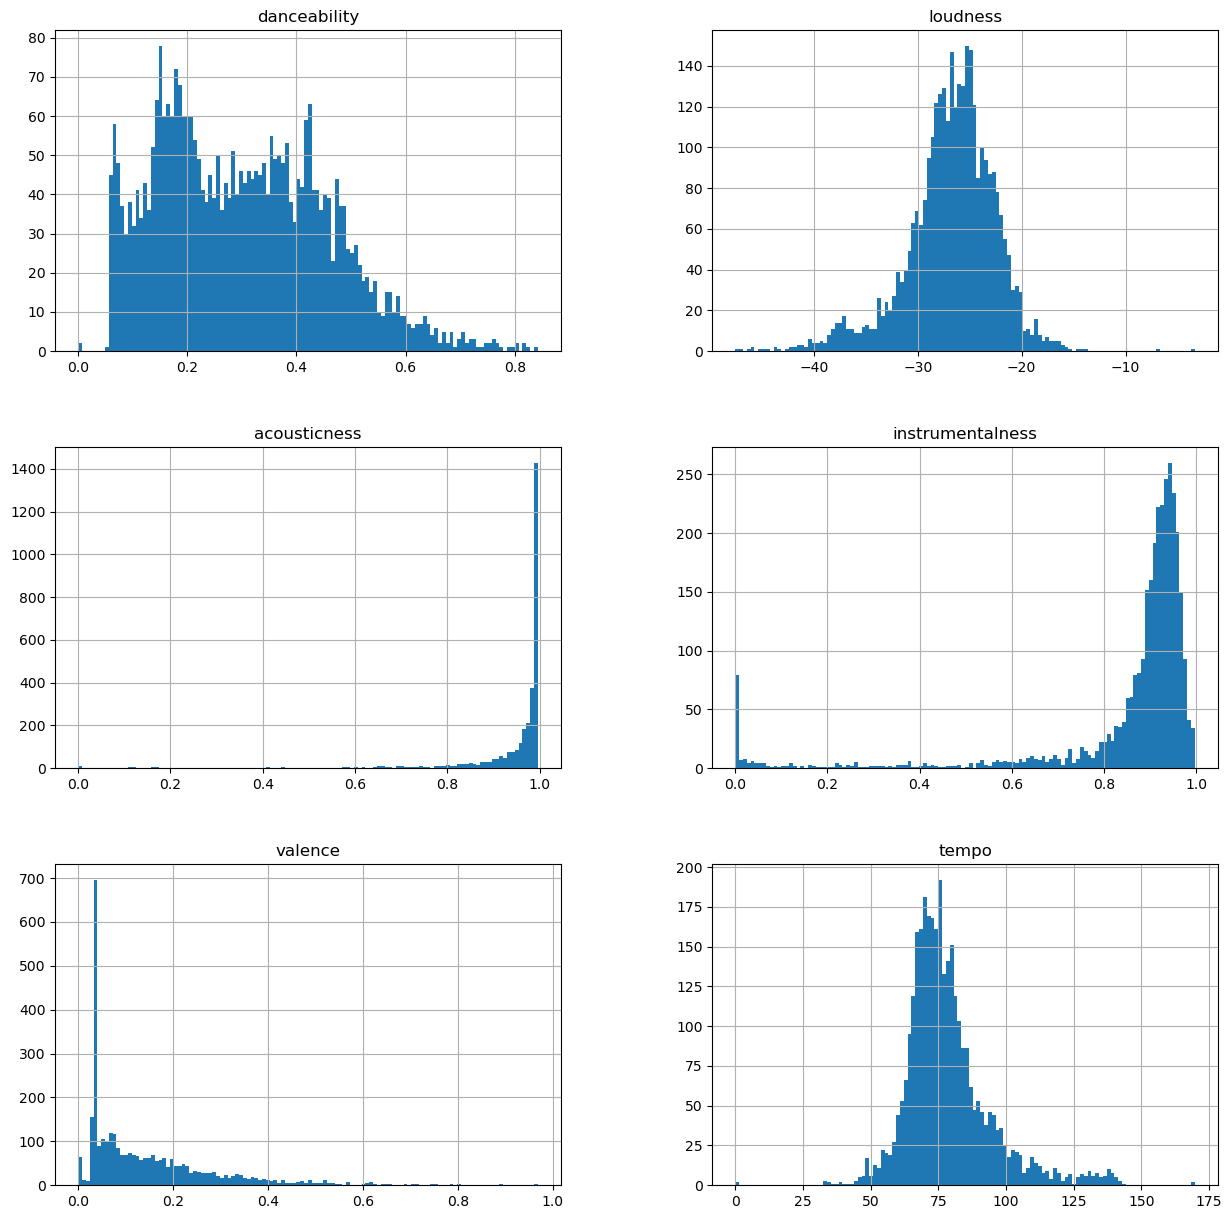

In [246]:
df_pearl_graf.hist(column = ['danceability','loudness','acousticness','instrumentalness','valence','tempo'], figsize = (15,15), bins = 120)
plt.show()

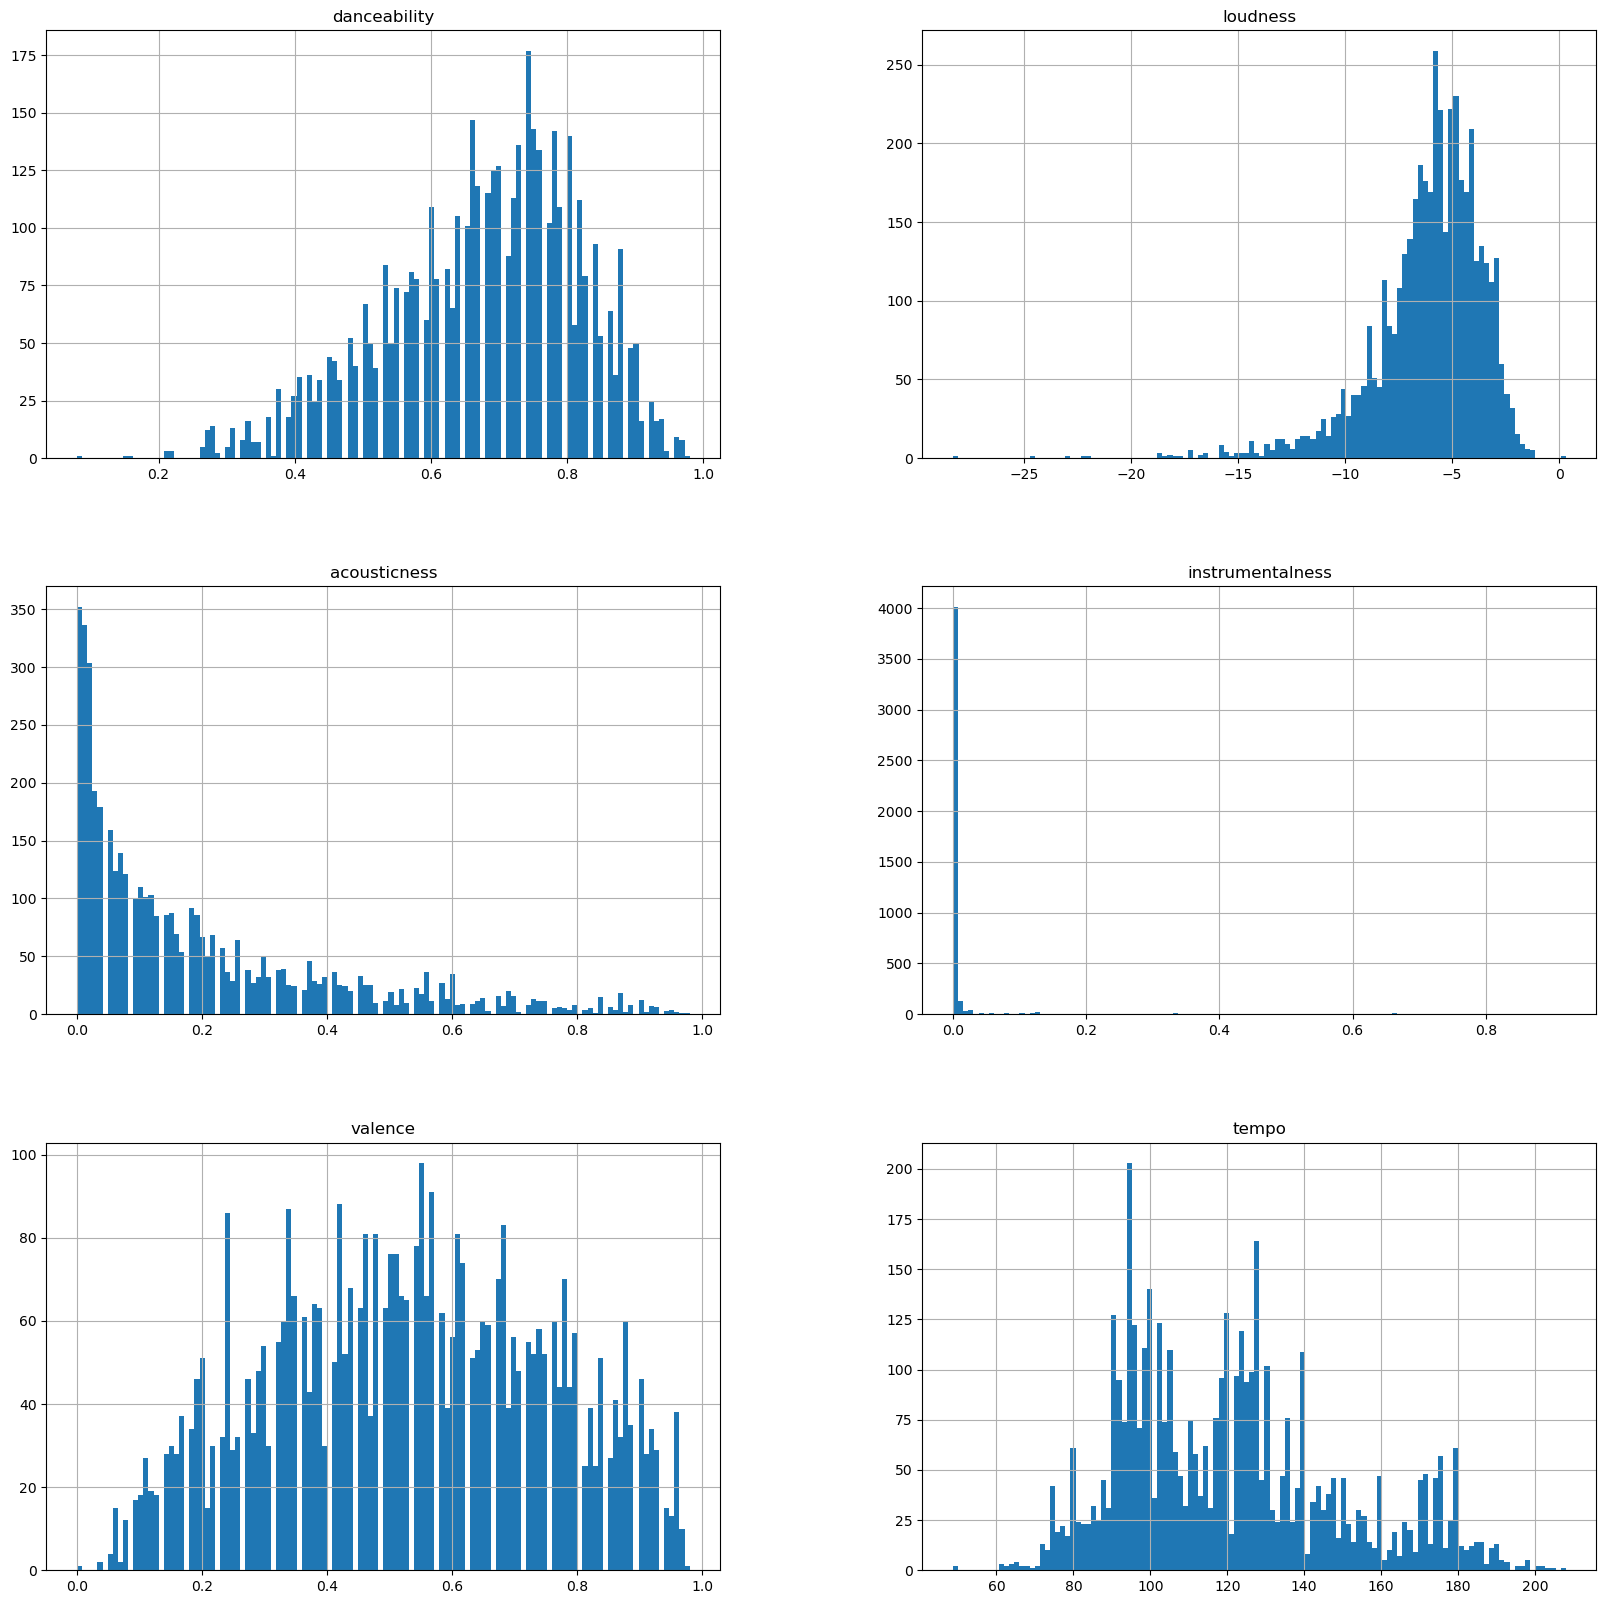

In [247]:
df_Canciones_top.hist(column = ['danceability','loudness','acousticness','instrumentalness','valence','tempo'],figsize = (20,20), bins = 120)
plt.show()

In [224]:
df_pearl.head()

,popularity,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,control,predicted_popularity
2733,53,0.07,9,-24.01,0,0.04,0.86,0.92,0.10,0.05,80.49,0,1
2745,50,0.28,4,-14.32,0,0.03,0.66,0.98,0.10,0.08,39.37,0,1
2751,45,0.51,1,-23.25,1,0.04,0.99,0.88,0.14,0.05,73.36,0,1
2754,39,0.08,11,-21.73,1,0.04,0.85,0.83,0.10,0.03,56.58,0,1
2764,38,0.11,11,-22.85,1,0.04,0.92,0.89,0.09,0.03,72.66,0,1
